In [0]:
pip install geopandas

     |████████████████████████████████| 931kB 42.0MB/s 
     |████████████████████████████████| 14.7MB 209kB/s 
     |████████████████████████████████| 10.4MB 51.2MB/s 


In [0]:
## Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(14)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [0]:
## import the data
raw_df = pd.read_csv('/content/Clean.csv', sep=";", encoding='cp1252')
## print statement to show number of rows
print(f"The dataset contains {len(raw_df)} Airbnb listings")
## display all the columns
pd.set_option('display.max_columns', len(raw_df.columns)) 
## see 100 rows when looking at dataframe
pd.set_option('display.max_rows', 100)
## inspect the first three rows
raw_df.head(3)

ParserError: ignored

In [0]:
## check number of columns
raw_df.shape

(24586, 106)

In [0]:
## drop columns that are non-numeric
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

In [0]:
## check for nan values
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         28
host_response_time                              10761
host_response_rate                              10761
host_acceptance_rate                            24586
host_is_superhost                                  28
host_listings_count                                28
host_total_listings_count                          28
host_has_profile_pic                               28
host_identity_verified                             28
street                                              0
neighbourhood                                      71
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                               10
state                                             125
zipcode                                           538
market                      

In [0]:
## drop columns with large amounts of nans
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)


In [0]:
## set the index to be id 
df.set_index('id', inplace=True) 

In [0]:
## drop highly correlated or repetitive  columns
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [0]:
## save latitude and longitude data
lat_long = df[['latitude', 'longitude']]

In [0]:
## drop columns related to location since we are in Berlin exclusivly and we saved latitude and longitude 
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [0]:
## drop columns highly correlated with nights/stayed
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

In [0]:
df.head()

,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1944,none,2008-08-16,a few days or more,33%,f,0.0,t,t,Brunnenstr. Nord,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{""Cable TV"",Internet,Wifi,""Free street parking...",$21.00,$0.00,$0.00,1,$10.00,60,120,11 months ago,t,9,25,25,251,18,0,2013-09-07,2018-11-11,82.0,9.0,8.0,9.0,9.0,9.0,8.0,t,f,f,moderate,f,f,0.24
3176,none,2008-10-19,a few days or more,0%,f,1.0,t,t,Prenzlauer Berg Südwest,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$90.00,$300.00,$100.00,2,$20.00,62,1125,2 months ago,t,9,39,69,344,145,1,2009-06-20,2019-06-27,93.0,9.0,9.0,9.0,9.0,10.0,9.0,t,f,f,strict_14_with_grace_period,f,f,1.14
3309,none,2008-11-07,NaN,NaN,f,1.0,t,f,Schöneberg-Nord,Apartment,Private room,1,1.0,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets live on this property"",Ca...",$28.00,$250.00,$30.00,1,$18.00,7,35,2 months ago,t,0,12,42,317,27,2,2013-08-12,2019-05-31,89.0,9.0,9.0,9.0,10.0,9.0,9.0,t,f,f,strict_14_with_grace_period,f,f,0.35
6883,none,2009-05-07,within an hour,100%,f,1.0,t,t,Frankfurter Allee Süd FK,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$125.00,$0.00,$39.00,1,$0.00,3,90,a week ago,t,15,20,20,20,128,4,2010-02-15,2019-10-21,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,f,moderate,f,t,1.08
7071,none,2009-05-16,within an hour,100%,t,2.0,t,t,Helmholtzplatz,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",$33.00,$0.00,$0.00,1,$25.00,3,10,3 days ago,t,21,30,30,30,266,69,2009-08-18,2019-11-09,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,f,moderate,f,f,2.13


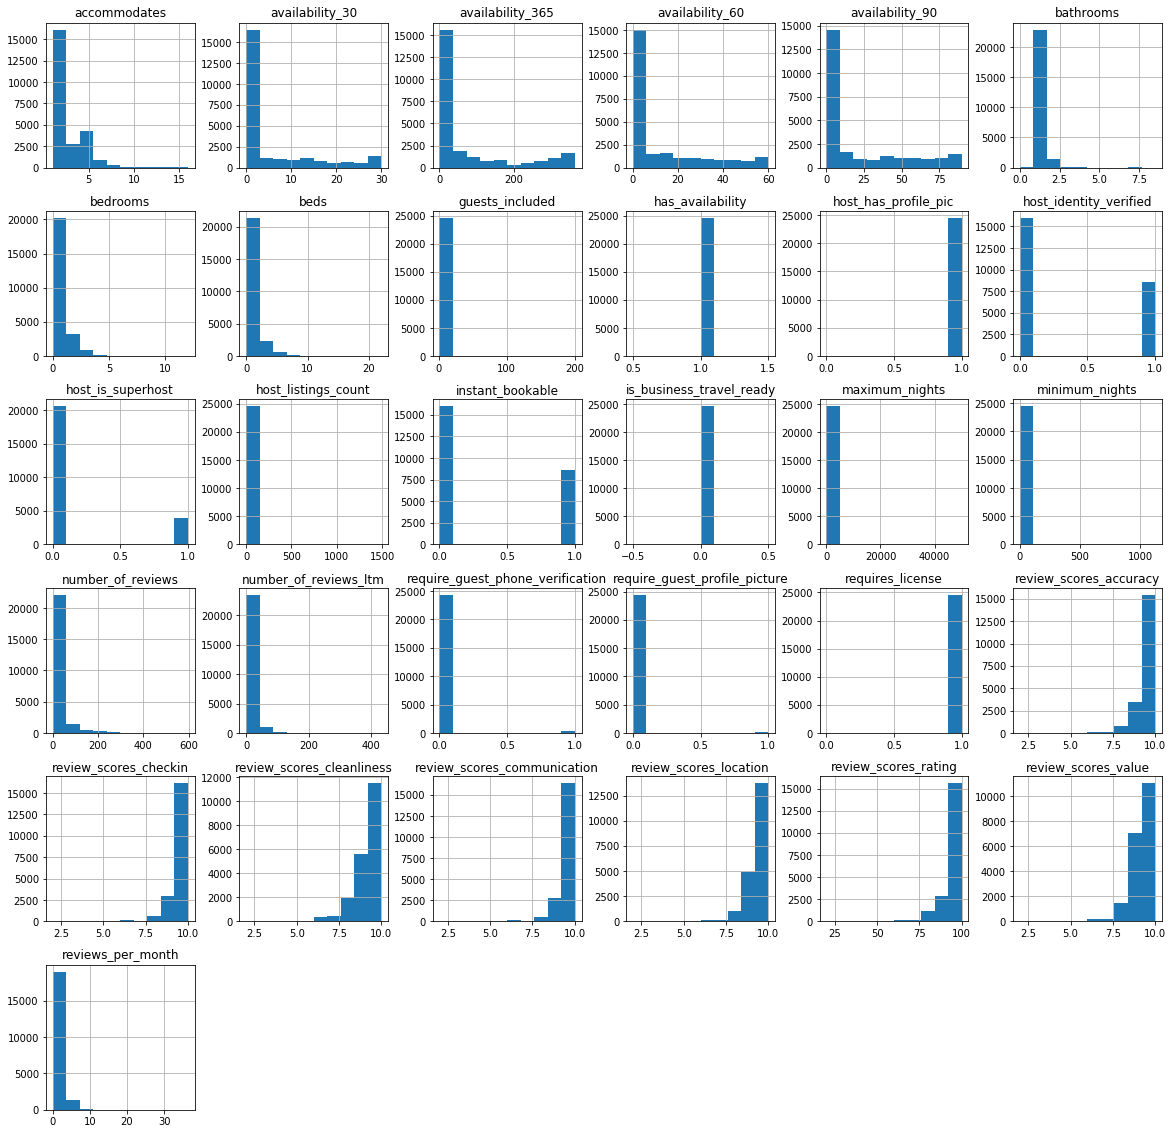

In [0]:
## Replacing columns with false/true with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

## Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [0]:
## if there is only one category that is not helpful so we'll drop those columns
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

In [0]:
## we have dropped a lot of non-essential columns
## now to clean the ones we have remaining
df.shape

(24586, 42)

In [0]:
## list remaining features
df.columns

Index(['experiences_offered', 'host_since', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'reviews_per_month'],
      dtype='object')

## Experiences offered

In [0]:
## not useful 
df.experiences_offered.value_counts()

none    24586
Name: experiences_offered, dtype: int64

In [0]:
## drop experiences_offered columns since it was all none
df.drop('experiences_offered', axis=1, inplace=True)

## Host Since

In [0]:
### Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

## Calculating the number of days host has been active up to day data was scraped
df['host_days_active'] = (datetime(2019, 11, 12) - df.host_since).astype('timedelta64[D]')

## Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

#@ Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1585.0
Median days as host: 1580.0


## Host response time

In [0]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Percentage Null: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not been reviewed
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 10761
Percentage Null: 43.8%


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


4081

In [0]:
## we are going to make an unknown category for later use
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.437688
within an hour        0.297974
within a few hours    0.129261
within a day          0.114049
a few days or more    0.021028
Name: host_response_time, dtype: float64

## Host response rate

In [0]:
## check percetage of null values for this category
print("Null values:", df.host_response_rate.isna().sum())
print(f"Percentage Null: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 10761
Percentage Null: 43.8%


In [0]:
## Remove % sign from the host_response_rate string and converting to an integer for machine learning
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
## inspect response rates
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())

Mean host response rate: 92.0
Median host response rate: 100.0


In [0]:
## Categorize and bin response rate categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

## Convert to string
df.host_response_rate = df.host_response_rate.astype('str')

## Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

## Category counts
df.host_response_rate.value_counts()

unknown    10761
100%        9814
50-89%      2444
0-49%        784
90-99%       783
Name: host_response_rate, dtype: int64

## superhost

In [0]:
## find the number of instances where superhost is null
## Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


28

In [0]:
## drop rows where multiple items are missing
df.dropna(subset=['host_since'], inplace=True)

## property type

In [0]:
## inspect feature
df.property_type.value_counts()

Apartment                 21824
Condominium                 656
Loft                        482
House                       470
Serviced apartment          297
Hostel                      188
Townhouse                   114
Hotel                        93
Boutique hotel               89
Guest suite                  71
Guesthouse                   59
Bed and breakfast            37
Other                        34
Bungalow                     24
Houseboat                    17
Villa                        14
Aparthotel                   13
Boat                         12
Tiny house                   12
Camper/RV                    12
Cottage                       8
Pension (South Korea)         8
Cabin                         7
Barn                          5
Treehouse                     3
Castle                        3
Lighthouse                    1
Earth house                   1
Resort                        1
Tipi                          1
Cave                          1
Casa par

In [0]:
## Categorize properties as house or apartment
df.property_type.replace({
    'Condominium' : 'House',
    'Loft' : 'Apartment',
    'Serviced apartment': 'Apartment',
    'Townhouse' : 'House',
    'Hotel' : 'Apartment',
    'Boutique hotel' : 'Apartment',
    'Guest suite' : 'Apartment',
    'Guesthouse' : 'House',
    'Bungalow': 'House',
    'Houseboat' : 'House',
    'Villa' : 'House',
    'Aparthotel' : 'Apartment',
    'Tiny house': 'House',
    'Cottage' : 'House',
    'Treehouse' : 'House',
    'Castle' : 'House',
    'Lighthouse' : 'House',
    'Earth house': 'House'  
    }, inplace=True)


In [0]:
## Replace all the other categories with category type other
## if its not an apartment or a house its other
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [0]:
## inspect our work
df.property_type.value_counts()

Apartment    22869
House         1382
Other          307
Name: property_type, dtype: int64

## bathrooms, bedrooms and beds

In [0]:
## for loop that will go through these three columns
## it will fill the median value for each column
## we are using median values so we don't have .73 bedrooms or something wierd like that
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

## bed type

In [0]:
## inspect values
df.bed_type.value_counts(normalize=True)

Real Bed         0.973084
Pull-out Sofa    0.015229
Futon            0.008388
Couch            0.002565
Airbed           0.000733
Name: bed_type, dtype: float64

In [0]:
## since 97% have the same value this feature will be dropped
df.drop('bed_type', axis=1, inplace=True)

## amenities

In [0]:
## inspect amenities for a listing
# Example of amenities listed
df.amenities[:1].values

array(['{"Cable TV",Internet,Wifi,"Free street parking",Heating,"Family/kid friendly",Washer,"Smoke detector",Essentials,"Lock on bedroom door","Hair dryer","Hot water","Host greets you"}'],
      dtype=object)

In [0]:
# Creating a set of all possible unique amenities
## cast the array as list
amenities_list = list(df.amenities)
## join all the words together using empty space
amenities_list_string = " ".join(amenities_list)
## replace open brackets with empty space
amenities_list_string = amenities_list_string.replace('{', '')
## replace closing brackets with comma
amenities_list_string = amenities_list_string.replace('}', ',')
## remove extra punctuation
amenities_list_string = amenities_list_string.replace('"', '')
## strip whitespace and split on commas
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
## remove duplicates
amenities_set = set(amenities_set)
## inspect our work
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'En suite bathroom',
 'Espresso machine',
 'Essent

In [0]:
## we can bin many of these amenities together

## change 24 hour check in to a better format
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1

## handicap accessible 
df.loc[df['amenities'].str.contains('Accessible-height bed|Flat path to guest entrance|Step-free shower|No stairs or steps to enter|Fixed grab bars for toilet|Fixed grab bars for shower|Accessible-height toilet|Wide entryway|Wide hallways|Wide entrance for guests|Wide entrance|Wide doorway to guest bathroom|Wide clearance to shower|Disabled parking spot'), 'handicap_accessible'] = 1



In [0]:
## add category for high_end_electronics
df.loc[df['amenities'].str.contains('Amazon Echo|HBO GO|High-resolution computer monitor|Sound system|Printer|Laptop friendly workspace|DVD player|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1

In [0]:
## add category for air conditioning
df.loc[df['amenities'].str.contains('Air conditioning|Heating'), 'air_conditioning'] = 1

In [0]:
## add category for general appliances
df.loc[df['amenities'].str.contains('Convection oven|Essentials|Stove|Refrigerator|Oven|Microwave|Gas oven|Double oven|Dishwasher'), 'standard_appliances'] = 1

In [0]:
## add category for high end appliances
df.loc[df['amenities'].str.contains('Air purifier|Wine cooler|Mobile hoist|Mini fridge|Steam oven|Room-darkening shades|Indoor fireplace|Hot water kettle|Heated floors|Electric profiling bed|Ceiling hoist|Ceiling fan|'), 'high_end_appliances'] = 1

In [0]:
## add category for standard bath amenities
df.loc[df['amenities'].str.contains('Bath towel|Hot water|toilet|Walk-in shower|Toilet paper|Shampoo|Hair dryer|Soaking tub|Body soap|Bathtub|Bathroom essentials'), 'standard_bathroom_items'] = 1

In [0]:
## add category for high end bath amenities
df.loc[df['amenities'].str.contains('Bathtub with bath chair|En suite bathroom|Warming drawer|Stand alone steam shower|Shower chair|Rain shower|Heated towel rack|Handheld shower head|Bidet'), 'bathroom_items_luxury'] = 1

In [0]:
## add category for laundry essentials
df.loc[df['amenities'].str.contains('Dryer|Washer / Dryer|Washer|Hangers|Iron'), 'laundry_essentials'] = 1

In [0]:
## add category for kitchen essentials
df.loc[df['amenities'].str.contains('Cooking basics|Kitchenette|Dishes and silverware'), 'kitchen_essentials'] = 1

In [0]:
## add category for high end kitchen items
df.loc[df['amenities'].str.contains('Breakfast table|Formal dining area|Kitchen|Full kitchen'), 'kitchen_luxury'] = 1

In [0]:
## add category for kid friendly
df.loc[df['amenities'].str.contains('Baby bath|Stair gates|Pack ’n Play/travel crib|High chair|Family/kid friendly|Crib|Children’s dinnerware|Children’s books and toys|Changing table|Babysitter recommendations|Baby monitor'), 'child_friendly'] = 1

In [0]:
## add category for safety and security
df.loc[df['amenities'].str.contains('Buzzer/wireless intercom|Well-lit path to entrance|Window guards|Table corner guards|Smoke detector|Smart lock|Safety card|Outlet covers|Lockbox|Lock on bedroom door|Keypad|First aid kit|Fireplace guards|Fire extinguisher|Carbon monoxide detector'), 'safety_and_security'] = 1

In [0]:
## add category for outdoor space
df.loc[df['amenities'].str.contains('Balcony|Sun loungers|Terrace|Patio or balcony|Hammock|Outdoor seating|Mudroom|Fire pit|Garden or backyard'), 'outdoor_space'] = 1

In [0]:
## add category for bbq
df.loc[df['amenities'].str.contains('BBQ grill'), 'bbq'] = 1

In [0]:
## add category for natural amenities
df.loc[df['amenities'].str.contains('Beach view|Beach essentials|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1

In [0]:
## add category for tv
df.loc[df['amenities'].str.contains('TV|Cable TV'), 'tv'] = 1

In [0]:
## add category for pets
df.loc[df['amenities'].str.contains('Pets|Pets live on this property|Pets allowed|Other pet(s)|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [0]:
## add category for bedding essentials
df.loc[df['amenities'].str.contains('Bed linens|Firm mattress'), 'bedding_essentials'] = 1

In [0]:
## add category for bedding essentials
df.loc[df['amenities'].str.contains('Bedroom comforts|Pillow-top mattress|Murphy bed|Memory foam mattress|Extra space around bed|Day bed|Extra pillows and blankets'), 'bedding_luxury'] = 1

In [0]:
## add category for coffee machines
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1

In [0]:
## add category for included breakfast
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1

In [0]:
## add category for internet access
df.loc[df['amenities'].str.contains('Internet|Ethernet connection|Pocket wifi|Wifi'), 'internet'] = 1

In [0]:
## add category for onsite staff
df.loc[df['amenities'].str.contains('Building staff|Standing valet|Doorman'), 'onsite_staff'] = 1

In [0]:
## add category for cleaning before checkout
df.loc[df['amenities'].str.contains('Cleaning before checkout'), 'clean_before_checkout'] = 1

In [0]:
## add category for EV charger
df.loc[df['amenities'].str.contains('EV charger'), 'ev_charger'] = 1

In [0]:
## add category for elevator
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1

In [0]:
## add category for free parking
df.loc[df['amenities'].str.contains('Free parking on premises|Outdoor parking|Free street parking'), 'free_parking'] = 1

In [0]:
## add category for ground floor 
df.loc[df['amenities'].str.contains('Ground floor access|Single level home'), 'ground_floor'] = 1

In [0]:
## add category for gym
df.loc[df['amenities'].str.contains('Gym'), 'gym'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1

In [0]:
## add category for hot tub or pool
df.loc[df['amenities'].str.contains('Hot tub|Pool|Pool with pool hoist'), 'hot_tub_or_pool'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Luggage dropoff allowed'), 'luggage_dropoff'] = 1

In [0]:
## add category for other
df.loc[df['amenities'].str.contains('Other|translation missing: en.hosting_amenity_50|translation missing: en.hosting_amenity_49'), 'other'] = 1

In [0]:
## add category for paid parking
df.loc[df['amenities'].str.contains('Paid parking off premises|Paid parking on premises'), 'paid_parking'] = 1

In [0]:
## add category for privacy 
df.loc[df['amenities'].str.contains('Private bathroom|Private entrance|Private hot tub|Private living room'), 'privacy'] = 1

In [0]:
## add category for self check in
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1

In [0]:
## add category for host greets you
df.loc[df['amenities'].str.contains('Suitable for events'), 'suitable_for_events'] = 1

In [0]:
## reduce dimensionality by dropping infrequent amenities
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'handicap_accessible', 'bathroom_items_luxury', 'bbq', 'nature_and_views', 'breakfast', 'onsite_staff', 'clean_before_checkout', 'ev_charger', 'ground_floor', 'gym', 'hot_tub_or_pool', 'self_check_in', 'suitable_for_events']


In [0]:
## inspect frequently occuring amenities
df.columns[40:]

Index(['high_end_electronics', 'air_conditioning', 'standard_appliances',
       'high_end_appliances', 'standard_bathroom_items', 'laundry_essentials',
       'kitchen_essentials', 'kitchen_luxury', 'child_friendly',
       'safety_and_security', 'outdoor_space', 'tv', 'pets_allowed',
       'bedding_essentials', 'bedding_luxury', 'coffee_machine', 'internet',
       'elevator', 'free_parking', 'host_greeting', 'long_term_stays',
       'luggage_dropoff', 'other', 'paid_parking', 'privacy',
       'smoking_allowed'],
      dtype='object')

## price

In [0]:
## for price we need to convert it from string to integer and remove money sign
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [0]:
## inspect changes
df.price

id
1944         21
3176         90
3309         28
6883        125
7071         33
           ... 
40055760     77
40057919    140
40061108     20
40070345     35
40086295     35
Name: price, Length: 24558, dtype: int64

## security deposit

In [0]:
## convert this string into an integer 
## remove currency symbol
## fill empty values with 0 meaning no security deposit
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

## cleaning fee

In [0]:
## same as above
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

## extra people

In [0]:
## same as above
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

## calender updated

In [0]:
## check number of categories
df.calendar_updated.nunique()

87

In [0]:
df.calendar_updated.value_counts(normalize=True)

today            0.070771
2 months ago     0.064989
2 weeks ago      0.061324
a week ago       0.060347
3 months ago     0.042308
3 weeks ago      0.041779
4 weeks ago      0.033675
yesterday        0.033513
4 months ago     0.032739
3 days ago       0.027852
5 weeks ago      0.025124
6 weeks ago      0.022152
2 days ago       0.020319
4 days ago       0.020319
5 months ago     0.019871
6 months ago     0.014659
5 days ago       0.014415
16 months ago    0.014048
7 months ago     0.014008
8 months ago     0.013845
23 months ago    0.013356
27 months ago    0.011809
9 months ago     0.011687
10 months ago    0.011646
20 months ago    0.011564
7 weeks ago      0.011483
11 months ago    0.010750
28 months ago    0.010669
24 months ago    0.010546
21 months ago    0.010506
18 months ago    0.009814
22 months ago    0.009732
17 months ago    0.009610
15 months ago    0.009406
26 months ago    0.009325
19 months ago    0.009284
1 week ago       0.009040
12 months ago    0.008348
14 months ag

In [0]:
## too much variation, this feature will be dropped
df.drop('calendar_updated', axis=1, inplace=True)

## availability

In [0]:
## more than 90 days is no longer short term rental so we will drop more than 90 days
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

## first review last review

In [0]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 11, 12) - df.first_review).astype('timedelta64[D]')

In [0]:
## function to categorize review duration
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [0]:
## Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [0]:
## repeat the process for last review
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 11, 12) - df.last_review).astype('timedelta64[D]')

In [0]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [0]:
## Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

## review ratings columns

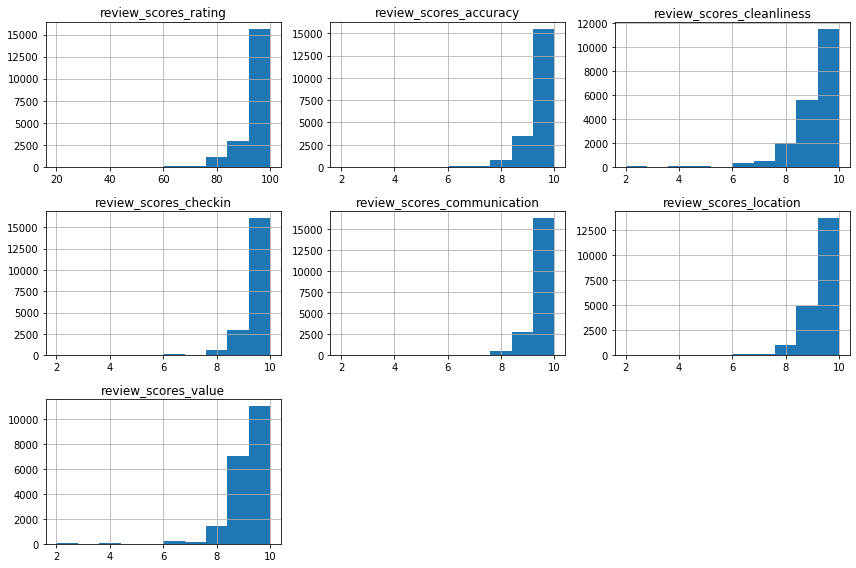

In [0]:
## rooms with no review will be unknown
## others will be binned
## visualize distributions
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [0]:
## remove review_scores_rating because it is out of 100 not 10 like the others
variables_to_plot.pop(0)

'review_scores_rating'

In [0]:
## Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [0]:
## Binning column scored out of 100
## dividing by 100 to match other ratings categories
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

## Cancellation policy

In [0]:
## view value counts
df.cancellation_policy.value_counts()

flexible                       9621
moderate                       7430
strict_14_with_grace_period    7364
super_strict_30                  81
super_strict_60                  60
strict                            2
Name: cancellation_policy, dtype: int64

In [0]:
## place stricts all into the same category
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    }, inplace=True)

In [0]:
## inspect changes
df.cancellation_policy.value_counts(normalize=True)

flexible                       0.391766
strict_14_with_grace_period    0.305685
moderate                       0.302549
Name: cancellation_policy, dtype: float64

## number_of_reviews_ltm and reviews_per_month

In [0]:
## These will be highly correlated with number_of_reviews and so will be dropped
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [0]:
## inspect dataframe
df.head()

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,host_days_active,high_end_electronics,air_conditioning,standard_appliances,high_end_appliances,standard_bathroom_items,laundry_essentials,kitchen_essentials,kitchen_luxury,child_friendly,safety_and_security,outdoor_space,tv,pets_allowed,bedding_essentials,bedding_luxury,coffee_machine,internet,elevator,free_parking,host_greeting,long_term_stays,luggage_dropoff,other,paid_parking,privacy,smoking_allowed,time_since_first_review,time_since_last_review
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1944,2008-08-16,a few days or more,0-49%,0.0,0.0,1.0,Brunnenstr. Nord,Apartment,Private room,1,1.0,1.0,1.0,21,0,0,1,10,60,120,25,18,2013-09-07,80-94/100,9/10,0-8/10,9/10,9/10,9/10,0-8/10,0,moderate,4105.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4+ years,1+ year
3176,2008-10-19,a few days or more,0-49%,0.0,1.0,1.0,Prenzlauer Berg Südwest,Apartment,Entire home/apt,4,1.0,1.0,2.0,90,300,100,2,20,62,1125,69,145,2009-06-20,80-94/100,9/10,9/10,9/10,9/10,10/10,9/10,0,strict_14_with_grace_period,4041.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4+ years,2-6 months
3309,2008-11-07,unknown,unknown,0.0,1.0,0.0,Schöneberg-Nord,Apartment,Private room,1,1.0,1.0,1.0,28,250,30,1,18,7,35,42,27,2013-08-12,80-94/100,9/10,9/10,9/10,10/10,9/10,9/10,0,strict_14_with_grace_period,4022.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,2-6 months
6883,2009-05-07,within an hour,100%,0.0,1.0,1.0,Frankfurter Allee Süd FK,Apartment,Entire home/apt,2,1.0,1.0,1.0,125,0,39,1,0,3,90,20,128,2010-02-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,moderate,3841.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4+ years,2-8 weeks
7071,2009-05-16,within an hour,100%,1.0,2.0,1.0,Helmholtzplatz,Apartment,Private room,2,1.0,1.0,2.0,33,0,0,1,25,3,10,30,266,2009-08-18,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,moderate,3832.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4+ years,0-2 weeks


In [0]:
df.shape

(24558, 61)

In [0]:
## Dropping columns that are not useful to price analysis
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

# Numerical features

In [0]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,high_end_electronics,air_conditioning,standard_appliances,high_end_appliances,standard_bathroom_items,laundry_essentials,kitchen_essentials,kitchen_luxury,child_friendly,safety_and_security,outdoor_space,tv,pets_allowed,bedding_essentials,bedding_luxury,coffee_machine,internet,elevator,free_parking,host_greeting,long_term_stays,luggage_dropoff,other,paid_parking,privacy,smoking_allowed
count,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.0,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000
mean,0.163083,3.289763,0.349662,2.679331,1.100884,1.160966,1.617681,72.399340,120.978378,19.543530,1.363995,8.437251,7.267163,598.838790,20.137470,21.319366,0.350069,1584.516084,0.659459,0.946046,0.923284,1.0,0.833985,0.943603,0.341477,0.937454,0.322705,0.694275,0.172327,0.458181,0.163002,0.290374,0.159133,0.238619,0.961194,0.222534,0.308168,0.249002,0.151356,0.142357,0.200505,0.109252,0.232999,0.187352
std,0.369449,29.712178,0.476873,1.567290,0.346966,0.670397,1.213319,213.404113,321.532061,25.679877,1.545330,11.663609,28.373341,633.288639,28.733954,44.514702,0.477001,789.339147,0.473901,0.225931,0.266146,0.0,0.372102,0.230692,0.474215,0.242149,0.467521,0.460723,0.377672,0.498258,0.369375,0.453944,0.365808,0.426248,0.193136,0.415957,0.461746,0.432444,0.358403,0.349423,0.400386,0.311961,0.422750,0.390202
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,34.000000,0.000000,0.000000,1.000000,0.000000,2.000000,20.000000,0.000000,1.000000,0.000000,1032.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,50.000000,0.000000,12.000000,1.000000,5.000000,3.000000,1086.000000,0.000000,5.000000,0.000000,1580.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,78.000000,150.000000,30.000000,1.000000,15.000000,4.000000,1125.000000,40.000000,19.000000,1.000000,2145.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1492.000000,1.000000,16.000000,8.500000,12.000000,22.000000,8983.000000,4556.000000,500.000000,200.000000,250.000000,1124.000000,50000.000000,90.000000,596.000000,1.000000,4106.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [0]:
print(min(df.price), max(df.price))

0 8983


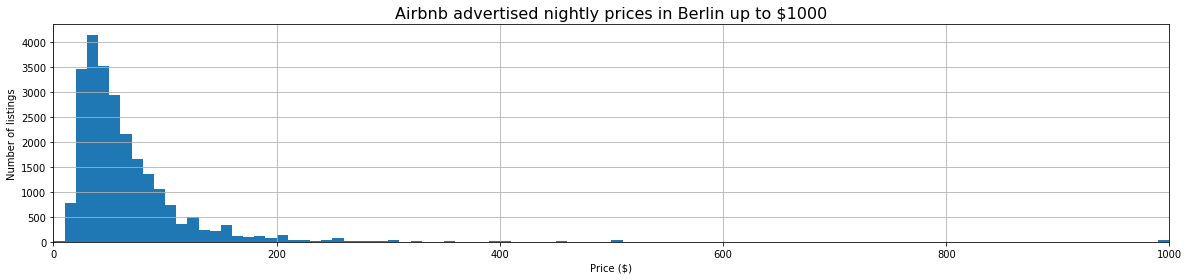

In [0]:
### Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in Berlin up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [0]:
## replace outlier values 

# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

## Getting data ready for machine learning

In [0]:
## one hot encoding
transformed_df = pd.get_dummies(df)

In [0]:
## Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [0]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

In [0]:
## Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [0]:
## split into features matrix and target vector

# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Neural Network to predict Price

In [0]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

In [0]:
## baseline XGboost machien learning model

xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:54:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.1475
Validation MSE: 0.1553

Training r2: 0.637
Validation r2: 0.626


In [0]:
## plot feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
neighbourhood_cleansed_Lichtenrade,0.000000
neighbourhood_cleansed_Müggelheim,0.000000
neighbourhood_cleansed_Neu-Hohenschönhausen Nord,0.000000
neighbourhood_cleansed_Neu-Hohenschönhausen Süd,0.000000
neighbourhood_cleansed_Neue Kantstraße,0.000000
...,...
cleaning_fee,0.028755
bathrooms,0.029838
accommodates,0.055081
room_type_Hotel room,0.061449


## Save model to send to data engineers

In [0]:
pwd

'/content'

In [0]:
import pickle

In [0]:
pickle.dump(xgb_reg, open( "model.pkl", "wb" ) )

In [0]:
new = open("/content/model.pkl", "rb")

In [0]:
airbnb = pickle.load(new)

[17:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
airbnb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
## commenting out so doesn't resave when running again
'''
with open('nn_model_pickle', 'wb') as f:
  pickle.dump(nn, f)
'''

In [0]:
## commenting out so doesn't resave when running again
'''
with open('processed_df_pickle', 'wb') as pickle_file:
  pickle.dump(transformed_df, pickle_file)
'''  